Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Class weights: {'cardboard': np.float64(1.0089820359281436), 'glass': np.float64(0.8446115288220551), 'metal': np.float64(1.046583850931677), 'paper': np.float64(0.7154989384288747), 'plastic': np.float64(0.8575063613231552), 'trash': np.float64(3.2718446601941746)}
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

=== Training Head ===
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 72s 876ms/step - accuracy: 0.1361 - loss: 1.8343 - val_accuracy: 0.0673 - val_loss: 1.7999 - learning_rate: 1.0000e-04
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.1581 - loss: 1.8260 - val_accuracy: 0.0653 - val_loss: 1.7983 - learning_rate: 1.0000e-04
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.1695 - loss: 1.8155 - val_accuracy: 0.0653 - val_loss: 1.7965 - learning_rate: 1.0000e-04
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms

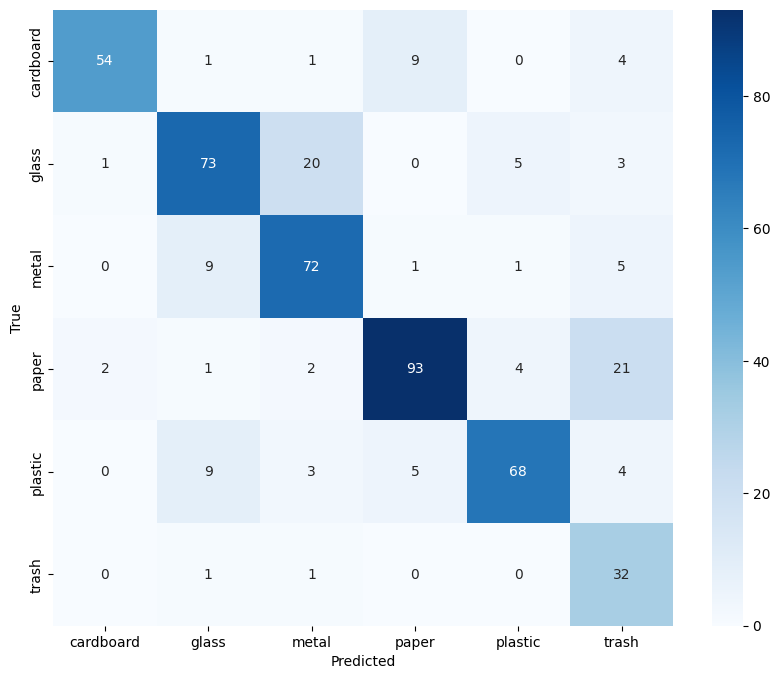

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import AdamW
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import os
import seaborn as sns

# ======================
# Configuration
# ======================
class Config:
    IMAGE_SIZE = (224, 224)  # EfficientNetV2B0 default size
    BATCH_SIZE = 32
    EPOCHS = 40
    DATA_DIR = "/content/TrashType_Image_Dataset"  # Update with your path
    CLASS_NAMES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    LR = 1e-4  # Lower learning rate for stability
    DROPOUT_RATE = 0.4

# ======================
# Data Pipeline
# ======================
def load_data():
    # Load dataset with automatic validation split
    train_ds = tf.keras.utils.image_dataset_from_directory(
        Config.DATA_DIR,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=Config.IMAGE_SIZE,
        batch_size=Config.BATCH_SIZE,
        label_mode='int'
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        Config.DATA_DIR,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=Config.IMAGE_SIZE,
        batch_size=Config.BATCH_SIZE,
        label_mode='int'
    )

    # Compute class weights for imbalance
    train_labels = np.concatenate([y for x, y in train_ds], axis=0)
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = dict(enumerate(class_weights))
    print("Class weights:", {Config.CLASS_NAMES[k]: v for k, v in class_weights.items()})

    # Optimize datasets
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)

    return train_ds, val_ds, class_weights

# ======================
# Model Architecture
# ======================
def build_model():
    # Data augmentation
    augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ], name="augmentation")

    # EfficientNetV2B0 base
    base_model = EfficientNetV2B0(
        include_top=False,
        weights="imagenet",
        input_shape=Config.IMAGE_SIZE + (3,),
        pooling='avg'
    )
    base_model.trainable = False  # Freeze initially

    # Build pipeline
    inputs = layers.Input(shape=Config.IMAGE_SIZE + (3,))
    x = augmentation(inputs)
    x = layers.Rescaling(1./255)(x)  # Simpler than EfficientNet's preprocessing
    x = base_model(x)
    x = layers.Dropout(Config.DROPOUT_RATE)(x)
    outputs = layers.Dense(len(Config.CLASS_NAMES), activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model, base_model

# ======================
# Training & Evaluation
# ======================
def train_and_evaluate():
    # Load data
    train_ds, val_ds, class_weights = load_data()

    # Build model
    model, base_model = build_model()

    # Compile with AdamW (better than Adam for small datasets)
    model.compile(
        optimizer=AdamW(learning_rate=Config.LR, weight_decay=1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Callbacks
    callbacks_list = [
        callbacks.EarlyStopping(patience=7, restore_best_weights=True),
        callbacks.ModelCheckpoint("best_model.keras", save_best_only=True),
        callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
    ]

    # Phase 1: Train head only
    print("\n=== Training Head ===")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=15,
        class_weight=class_weights,
        callbacks=callbacks_list
    )

    # Phase 2: Fine-tune
    print("\n=== Fine-Tuning ===")
    base_model.trainable = True
    model.compile(
        optimizer=AdamW(learning_rate=Config.LR/10),  # Lower LR for fine-tuning
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=Config.EPOCHS,
        initial_epoch=15,
        class_weight=class_weights,
        callbacks=callbacks_list
    )

    # Evaluation
    print("\n=== Evaluation ===")
    y_true = []
    y_pred = []
    for images, labels in val_ds:
        y_true.extend(labels.numpy())
        preds = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))

    print(classification_report(y_true, y_pred, target_names=Config.CLASS_NAMES))

    # Confusion matrix
    cm = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=Config.CLASS_NAMES,
                yticklabels=Config.CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Save final model
    model.save("trash_classifier_effnetv2b0.keras")

if __name__ == "__main__":
    train_and_evaluate()

In [7]:
# Install Gradio (if not already installed)
!pip install gradio -q

import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Make sure the model is loaded (use your trained model)
# If you've saved it, uncomment:
# model = tf.keras.models.load_model('garbage_classifier_mobilenetv2_finetuned.h5')

# Class names from your training
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

def predict_image(img):
    """Preprocess image and return predictions"""
    if img is None:
        return {c: 0.0 for c in class_names}

    try:
        # Convert and preprocess image
        img = tf.image.resize(img, (224, 224))
        img_array = preprocess_input(np.array(img))
        img_array = np.expand_dims(img_array, axis=0)

        # Get predictions
        predictions = model.predict(img_array, verbose=0)[0]
        return {class_names[i]: float(predictions[i]) for i in range(len(class_names))}
    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return {c: 0.0 for c in class_names}

# Create interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Upload trash image"),
    outputs=gr.Label(num_top_classes=3, label="Classification Results"),
    title="♻️ Smart Trash Classifier",
    description="Upload an image of trash to classify it (cardboard/glass/metal/paper/plastic/trash)",
    examples=[
        ["/content/drive/MyDrive/dataset/TrashType_Image_Dataset/cardboard/image1.jpg"],
        ["/content/drive/MyDrive/dataset/TrashType_Image_Dataset/plastic/image2.jpg"]
    ],
    allow_flagging="never"
)

# Launch with sharing enabled
try:
    interface.launch(share=True, debug=False)
except Exception as e:
    print(f"Gradio launch error: {str(e)}")
    interface.launch(debug=False)  # Fallback without sharing

/usr/local/lib/python3.11/dist-packages/gradio/interface.py:416: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0bf238a0b0181d245d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
